In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Обчислює теоретичну КДВ
import math
import cmath

# --- Глобальні змінні ---
R_vse = None
R_vseZ = None
R_vseZ_ML = None
DeltaTeta = None
DD = None
DDpd = None
Esum = None
DDPL1 = None
DDPL2 = None
DDparam = np.zeros(7)
km = 0
hpl0 = 0.0

m1  = 220   #1373
m10 = 20    #31
ik  = 10    #4.671897861
start_ML = 50
m1_ML=m1-start_ML
ML = False            # Без навчання (тільки демонастрація розрахунку КДВ)
Bicrystal = True      # False не працює!!!
Surface_Layer = True  # False не працює!!!
Polar_Sigma = True
Polar_Pi = False
Teta_in_Large = False

def Start():
    global psi, hpl, C, Lambda
    Lambda = 1.5405e-8
    psi = 0
    C = 1.0
    if Bicrystal is True:    hpl = 3.15e-4




# --- Функція GGG ---
def GGG():
    global a, d, ReChiRH, ImChiRH, ReChiIH, ImChiIH, ModChiRH, ModChiIH, ChiI0, ModChiI0
    a = 12.382e-8
    d = a / math.sqrt(4**2 + 4**2 + 4**2)
    ReChiRH = 14.5491e-6
    ImChiRH = 0.1587e-10
    ReChiIH = 3.8603e-6
    ImChiIH = 0.0352e-10
    ModChiRH = 14.5491e-6
    ModChiIH = 3.8603e-6
    ChiI0 = -4.2002e-6
    ModChiI0 = 4.2002e-6

# --- Функція YIG ---
def YIG():
    global apl, dpl, ReChiRHpl, ReChiIHpl, ModChiRHpl, ModChiIHpl, ChiI0pl, ModChiI0pl
    apl = 12.376e-8
    dpl = apl / math.sqrt(4**2 + 4**2 + 4**2)
    ReChiRHpl = 8.8269e-6
    ReChiIHpl = 0.9043e-6
    ModChiRHpl = 8.8269e-6
    ModChiIHpl = 0.9043e-6
    ChiI0pl = -2.1843e-6
    ModChiI0pl = 2.1843e-6

# --- Функція Profil ---
def Profil():
    global DD, Esum, km, dl, hpl0, DDPL1, DDPL2, DDparam

    # Параметри профілю деформації
    if (ML is False):
        Dmax1 = 0.01305
        D01 = 0.0017
        L1 = 5800e-8
        Rp1 = 3500e-8
        D02 = 0.004845
        L2 = 4000e-8
        Rp2 = -500e-8

        DDparam[0] = Dmax1
        DDparam[1] = D01
        DDparam[2] = L1
        DDparam[3] = Rp1
        DDparam[4] = D02
        DDparam[5] = L2
        DDparam[6] = Rp2
        print('  ***if (ML is False):****  ', DDparam[0], DDparam[1], DDparam[2], DDparam[3],DDparam[4])


    if (ML is True):
        Dmax1 = 0.01305
        D01 = 0.0017
        L1 = 5800e-8
        Rp1 = 3500e-8
        D02 = 0.004845
        L2 = 4000e-8
        Rp2 = -500e-8
        Dmax1 = DDparam[0]
        D01   = DDparam[1]
        L1    = DDparam[2]
        Rp1   = DDparam[3]
        D02   = DDparam[4]
        L2    = DDparam[5]
        Rp2   = DDparam[6]
        print('  ***if (ML is True):****  ', DDparam[0], DDparam[1], DDparam[2], DDparam[3],DDparam[4])


    Dmin = 0.0001
    dl = 100e-8

    s1 = (L1 - Rp1)**2 / np.log(Dmax1 / Dmin)
    s2 = Rp1**2 / np.log(Dmax1 / D01)
    s3 = L2 * (L2 - 2 * Rp2) / np.log(D02 / Dmin)
    ss = s2
    kk = 0

    DDPLk = Dmax1
    while DDPLk > Dmin:
        kk += 1
        z = dl * kk - dl / 2
        if z >= Rp1:
            ss = s1
        DDPLk = Dmax1 * np.exp(-(z - Rp1)**2 / ss)
        DDPLk += D02 * np.exp(Rp2**2 / s3) * np.exp(-(z - Rp2)**2 / s3)

    km = kk - 1
    L = km * dl
    hpl0 = hpl - L

    Dmax = 0
    ss = s1

    DD = np.zeros(km + 1)
    DDPL1 = np.zeros(km + 1)
    DDPL2 = np.zeros(km + 1)
    Esum = np.ones(km + 1)

    for k in range(1, km + 1):
        z = L - dl * k + dl / 2
        if z < Rp1:
            ss = s2
        DDPL1[k] = Dmax1 * np.exp(-(z - Rp1)**2 / ss)
        DDPL2[k] = D02 * np.exp(Rp2**2 / s3) * np.exp(-(z - Rp2)**2 / s3)
        DD[k] = DDPL1[k] + DDPL2[k]
        if Dmax < DD[k]:
            Dmax = DD[k]
        Esum[k] = 1
    #print (DD)
'''    # Збереження параметрів
    DDparam[0] = Dmax1
    DDparam[1] = D01
    DDparam[2] = L1 / 1e-8
    DDparam[3] = Rp1 / 1e-8
    DDparam[4] = D02
    DDparam[5] = L2 / 1e-8
    DDparam[6] = Rp2 / 1e-8'''


# --- Розрахунок когерентної складової ---
def RozrachKogerTT():
    global R_vse, DeltaTeta
    #m1  = 1373
    #m10 = 30
    #ik  = 4.671897861
    tb = math.asin(Lambda * math.sqrt(4**2 + 4**2 + 4**2) / (2 * a))
    gamma0 = math.sin(tb - psi)
    gammah = math.sin(tb + psi)
    b_as = gamma0 / abs(gammah)
    cmplxi = complex(0, 1)

    xhp0 = complex(ReChiRH, ReChiIH)
    xhn0 = complex(ReChiRH, ReChiIH)
    xhp = complex(ReChiRHpl, ReChiIHpl)
    xhn = complex(ReChiRHpl, ReChiIHpl)
    x0i0 = ChiI0
    x0i = ChiI0pl


    tb = math.asin(Lambda * math.sqrt(4**2 + 4**2 + 4**2) / (2 * a))
    #ik = 4.671897861
    apl_a = (apl - a) / a
    tan_tb = math.tan(tb)
    odpl = math.ceil(apl_a * tan_tb / (ik / 3600 * math.pi / 180))
    DD0 = odpl * (ik / 3600 * math.pi / 180) / tan_tb
    DDpd = (DD[:km + 1] + 1) * (DD0 + 1) - 1
    #print ('DD0=',DD0)

    '''if not Surface_Layer:
        hpl0 = hpl
    #if Surface_Layer is not True: hpl0=hpl
    #print ('hpl0=',hpl0)
    '''

    eta00 = math.pi * x0i0 * (1 + b_as) / (Lambda * gamma0)
    eta0 = math.pi * x0i * (1 + b_as) / (Lambda * gamma0)

    TetaMin = -m10 * ik
    Hteta = math.pi / (3600 * 180)
    DeltaTeta = np.array([TetaMin + i * ik for i in range(m1 + 1)])
    R_vse = np.zeros(m1 + 1)

    for i in range(m1 + 1):
        dtheta = DeltaTeta[i] * Hteta
        eta0pd = -(eta00 * cmplxi + 2 * math.pi * b_as * math.sin(2 * tb) * dtheta / (Lambda * gamma0))
        eta_val = -(eta0 * cmplxi + 2 * math.pi * b_as * math.sin(2 * tb) * dtheta / (Lambda * gamma0))

        sigmasp0 = math.pi * xhp0 * C / (Lambda * cmath.sqrt(gamma0 * gammah))
        sigmasn0 = math.pi * xhn0 * C / (Lambda * cmath.sqrt(gamma0 * gammah))
        sigmasp = math.pi * xhp * C / (Lambda * cmath.sqrt(gamma0 * gammah))
        sigmasn = math.pi * xhn * C / (Lambda * cmath.sqrt(gamma0 * gammah))

        sqs = cmath.sqrt(eta0pd**2 - 4 * sigmasp0 * sigmasn0)
        if sqs.imag <= 0:
            sqs = -sqs
        if eta00 <= 0:
            sqs = -sqs
        As = -(eta0pd + sqs) / (2 * sigmasn0)

        if Bicrystal is True:
           YYs0 = 2 * math.pi / d * DD0
           YYs0 = eta_val + YYs0
           sqs = cmath.sqrt((YYs0 / 2) * (YYs0 / 2) - sigmasp * sigmasn)
           if sqs.imag <= 0:
              sqs = -sqs
           if eta0 <= 0:
              sqs = -sqs
           ssigma = sqs / cmplxi
           x2s = -(YYs0 / 2 + sqs) / sigmasn
           x1s = -(YYs0 / 2 - sqs) / sigmasn
           x3s = (x1s - As) / (x2s - As)
           expcs = cmath.exp(-2 * ssigma * hpl0)
           As = (x1s - x2s * x3s * expcs) / (1 - x3s * expcs)

        if Surface_Layer is True:
            for k in range(1, km + 1):
                YYs_k = math.pi / Lambda / gamma0 * DDpd[k] * b_as * (
                math.cos(psi)**2 * math.tan(tb) + math.sin(psi) * math.cos(psi)) * 2 * math.sin(2 * tb)
                YYs_k = eta_val + YYs_k
                sqs = cmath.sqrt((YYs_k / 2)**2 - sigmasp * sigmasn * Esum[k]**2)
                if sqs.imag <= 0:
                    sqs = -sqs
                if eta0 <= 0:
                    sqs = -sqs
                ssigma = sqs / cmplxi
                x2s = -(YYs_k / 2 + sqs) / (sigmasn * Esum[k])
                x1s = -(YYs_k / 2 - sqs) / (sigmasn * Esum[k])
                x3s = (x1s - As) / (x2s - As)
                expcs = cmath.exp(-2 * ssigma * 400e-8)
                As = (x1s - x2s * x3s * expcs) / (1 - x3s * expcs)

        R_vse[i] = abs(xhp0 / xhn0) * abs(As)**2

# --- Згортка ---
def Zgortka():
    global R_vseZ, R_vseZ_ML
    w = 25
    A = 10000
    Ymin = 0.0001
    y0 = 0.
    xc = 0.
    #ik = 4.671897861
    #m10 = 30
    #m1 = 1373

    log_part = math.log((Ymin - y0) / ((A / w) * math.sqrt(2 * math.log(4) / math.pi)))
    Xmin = xc + math.sqrt(-w ** 2 / (2 * math.log(4)) * log_part)
    m10z = int(abs(Xmin) / ik)
    MZ = m10z * 2

    PO = np.zeros(MZ + 1)
    TetaMinz = -m10z * ik
    for i in range(MZ + 1):
        x = TetaMinz + i * ik
        PO[i] = y0 + (A / w * math.sqrt(2 * math.log(4) / math.pi) * math.exp(-2 * (x - xc) ** 2 * math.log(4) / w ** 2))
    PO /= np.sum(PO)

    POO = np.zeros(MZ + 2 * m10 + 1)
    for i in range(MZ, -1, -1):
        izg = i + (m10 - m10z)
        if izg < len(POO):
            POO[izg] = PO[i]

    R_vseZ = np.zeros(m1 + 1)
    for j in range(m1 + 1):
        for i in range(MZ + (m10 - m10z) + 1):
            idx = j - i + m10
            if 0 <= idx < len(R_vse):
                R_vseZ[j] += R_vse[idx] * POO[i]

    R_vseZ_ML = np.asarray(R_vseZ)[start_ML:m1]
# --- Вивід результатів ---
    # Побудова графіків Series2, Series3, Series4
def plot_profils():
    L=dl*km
    x_vals = [(L - dl * k + dl / 2) / 1e-8 for k in range(1, km + 1)]
    plt.figure(figsize=(5, 3))
    plt.plot(x_vals, DD[1:km + 1], label='DD (Total)', color='red')
    plt.plot(x_vals, DDPL1[1:km + 1], label='DDPL1 (Asymmetric Gaussian)', linestyle='--')
    plt.plot(x_vals, DDPL2[1:km + 1], label='DDPL2 (Decaying Gaussian)', linestyle=':')
    plt.xlabel('z (Å)')
    plt.ylabel('Deformation profile')
    plt.title('Deformation Profile Components')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


#def plot_results():
def plot_results(xlim=None, ylim=None, log_scale=True):

    plt.figure(figsize=(5, 3))
    plt.plot(DeltaTeta, R_vse, label='R_vse (Takagi-Taupin)', color='darkgreen')
    plt.plot(DeltaTeta, R_vseZ, label='R_vseZ (Convolved)', color='blue')
    plt.xlabel('Δθ (arcsec)')
    plt.ylabel('R (intensity)')
    plt.title('Scattering from Bicrystal (psi=1)')
    plt.grid(True)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if log_scale:
        plt.yscale('log')
    plt.xlim(-300, 2100)
    plt.tight_layout()
    plt.show()

# --- Основна програма ---
def main_XRD():
    Start()
    GGG()
    if Surface_Layer:
        YIG()
        Profil()  # hpl0 = hpl - L (розрахунок деформаційного профілю)
    else:
        global hpl0
        hpl0 = hpl  # немає деформаційного шару => вся товщина = недеформована частина
    RozrachKogerTT()
    Zgortka()
 #   plot_profils()
 #   plot_results()

if __name__ == '__main__':
    main_XRD()


  ***if (ML is False):****   0.01305 0.0017 5.8e-05 3.5e-05 0.004845


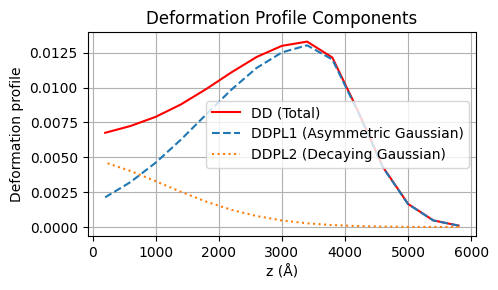

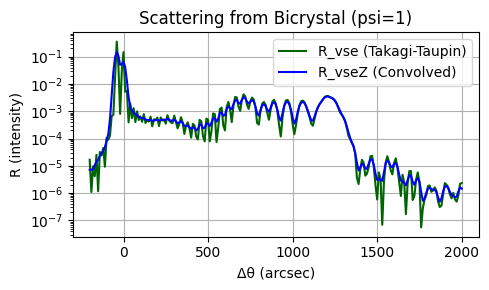

In [3]:
# Вивід графіків (профіль і КДВ)
plot_profils()
plot_results()

In [4]:
x = torch.linspace(0, m1_ML-1, m1_ML)  # 220 точок # Функція torch.linspace(start, end, steps) у PyTorch створює тензор із рівновіддалених чисел між start і end.
x

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14